In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [33]:
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from cuml.dask.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

In [34]:
# sample_submission = pd.read_csv('sample_submission.csv')               #('/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv')
train_labels = pd.read_csv('train_labels.csv')                    #('/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv')
train = pd.read_csv('train.csv')                           #('/kaggle/input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('test.csv')                            #('/kaggle/input/tabular-playground-series-apr-2022/test.csv')

In [35]:
# sample_submission

In [36]:
train_labels

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
25963,25963,1
25964,25964,0
25965,25965,1
25966,25966,1


In [37]:
train

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.20,0.11,1.00,0.33,-1.00,-0.13,-0.13,0.37,-0.10,-0.96,-0.99,0.53,4.75
1,0,47,1,-0.45,0.13,1.00,-0.66,0.16,0.34,-0.21,-0.87,0.20,-0.30,0.08,-0.23,0.45
2,0,47,2,0.33,-0.69,1.00,0.33,0.47,1.28,-0.09,0.54,1.40,1.00,0.45,-0.59,-4.74
3,0,47,3,0.52,0.75,1.00,0.98,-0.56,-0.72,0.79,0.95,-0.30,-1.00,-0.43,1.34,0.43
4,0,47,4,0.27,1.07,1.00,-0.14,0.40,0.04,0.56,-0.54,-0.90,1.06,0.81,0.12,-0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.28,-1.22,-1.67,0.59,-0.93,-0.45,-0.65,0.37,0.40,0.01,-0.72,-0.35,-0.91
1558076,25967,327,56,0.13,0.35,-1.67,-0.32,0.78,-0.33,0.10,0.12,-0.20,0.64,0.69,-0.61,-0.52
1558077,25967,327,57,-0.58,0.43,-1.67,0.32,0.31,0.28,-0.51,0.01,-1.60,-0.42,0.72,1.63,0.93
1558078,25967,327,58,1.28,1.71,-1.52,0.80,-0.46,-0.06,2.41,0.04,1.90,0.28,-0.91,0.36,0.21


In [38]:
test

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.43,19.64,1.00,-1.47,-1.29,-4.21,2.49,-2.49,8.00,-1.12,-1.67,10.98,0.42
1,25968,684,1,-4.95,-21.75,1.00,0.98,-0.57,1.85,-3.89,1.73,-2.90,0.40,-0.88,-1.87,-0.01
2,25968,684,2,1.14,-10.76,1.00,1.02,0.96,2.45,0.31,1.15,-5.60,1.11,1.53,-11.58,0.14
3,25968,684,3,0.81,6.50,1.00,-0.18,0.97,-1.04,-0.46,0.25,-2.70,-0.59,0.61,-4.24,-0.46
4,25968,684,4,1.29,5.55,1.00,-0.49,-1.04,-1.13,2.01,-0.73,0.00,0.90,-1.26,-0.47,-0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733075,38185,773,55,0.21,2.01,-1.33,0.70,-0.16,-1.19,0.42,0.87,0.00,-1.54,0.39,2.21,-91.61
733076,38185,773,56,-0.83,-2.47,-1.33,0.38,0.14,1.06,-0.77,0.29,0.20,-1.96,-0.03,-1.79,72.41
733077,38185,773,57,0.76,1.47,-1.33,-1.25,-0.41,0.01,0.91,-1.56,0.40,4.34,0.15,0.64,-34.07
733078,38185,773,58,-0.19,0.71,-1.33,0.08,1.32,0.16,-0.40,0.31,0.10,-1.01,-0.61,0.32,65.66


In [39]:
df_data = pd.merge(train, train_labels, how='inner', on = 'sequence')
df_data

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.20,0.11,1.00,0.33,-1.00,-0.13,-0.13,0.37,-0.10,-0.96,-0.99,0.53,4.75,0
1,0,47,1,-0.45,0.13,1.00,-0.66,0.16,0.34,-0.21,-0.87,0.20,-0.30,0.08,-0.23,0.45,0
2,0,47,2,0.33,-0.69,1.00,0.33,0.47,1.28,-0.09,0.54,1.40,1.00,0.45,-0.59,-4.74,0
3,0,47,3,0.52,0.75,1.00,0.98,-0.56,-0.72,0.79,0.95,-0.30,-1.00,-0.43,1.34,0.43,0
4,0,47,4,0.27,1.07,1.00,-0.14,0.40,0.04,0.56,-0.54,-0.90,1.06,0.81,0.12,-0.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.28,-1.22,-1.67,0.59,-0.93,-0.45,-0.65,0.37,0.40,0.01,-0.72,-0.35,-0.91,0
1558076,25967,327,56,0.13,0.35,-1.67,-0.32,0.78,-0.33,0.10,0.12,-0.20,0.64,0.69,-0.61,-0.52,0
1558077,25967,327,57,-0.58,0.43,-1.67,0.32,0.31,0.28,-0.51,0.01,-1.60,-0.42,0.72,1.63,0.93,0
1558078,25967,327,58,1.28,1.71,-1.52,0.80,-0.46,-0.06,2.41,0.04,1.90,0.28,-0.91,0.36,0.21,0


In [40]:
def details(df):
    sum_null_values = df.isnull().sum()
    percent_null_values = 100* (sum_null_values/len(df))
    data_type = df.dtypes
    unique_values = df.nunique()

    table = pd.concat([sum_null_values,percent_null_values,data_type,unique_values], axis=1)
    table_col = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Missing Values', 2 : 'Data_Type', 3: 'Unique values'})
    return table_col

In [41]:
details(df_data)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
sequence,0,0.00,int64,25968
subject,0,0.00,int64,672
step,0,0.00,int64,60
sensor_00,0,0.00,float64,25792
sensor_01,0,0.00,float64,28326
sensor_02,0,0.00,float64,4771
sensor_03,0,0.00,float64,26976
sensor_04,0,0.00,float64,387971
sensor_05,0,0.00,float64,22839
sensor_06,0,0.00,float64,25078


In [42]:
details(test)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
sequence,0,0.00,int64,12218
subject,0,0.00,int64,319
step,0,0.00,int64,60
sensor_00,0,0.00,float64,21406
sensor_01,0,0.00,float64,20810
sensor_02,0,0.00,float64,3832
sensor_03,0,0.00,float64,20963
sensor_04,0,0.00,float64,291764
sensor_05,0,0.00,float64,20480
sensor_06,0,0.00,float64,19154


In [43]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

df_data = reduce_mem_usage(df_data)

Mem. usage decreased to 98.07 Mb (54.2% reduction)


In [44]:
df = df_data.copy()

In [45]:
df.groupby(['step','subject','sequence'])['sensor_00', 'sensor_01', 'sensor_02','sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07','sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12'].mean()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
step subject sequence                                                          
0    0       207            0.59       0.63       1.00       0.39      -0.66   
             1124           0.26       0.04       0.33       0.30      -0.26   
             1174          -1.06       0.42       0.67       0.20       0.49   
             5008           1.44       0.80       0.67       1.35       2.62   
             6119           0.35      -0.33       0.67      -0.10      -0.67   
...                          ...        ...        ...        ...        ...   
59   671     24825         -0.16      -0.17       0.33      -0.85       0.16   
             25219         -0.11      -0.02       1.00       0.50       0.24   
             25507         -0.06      -0.22       0.67       0.15      -0.25   
             25607         -2.00       0.13       0.00      -0.38      -2.11   
             25870          0.07      -0.97       0.00       1.00       1.45   

                       sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
step subject sequence                                                          
0    0       207            0.02       0.49       0.10      -0.30       0.12   
             1124           0.42       0.26       0.25      -1.10       1.91   
             1174          -0.43      -0.75      -0.52      -0.20      -0.92   
             5008           2.12       1.63       0.83       0.30       1.01   
             6119           0.12       0.24      -0.01       0.80       0.22   
...                          ...        ...        ...        ...        ...   
59   671     24825          1.40      -0.74      -0.58      -0.70       0.90   
             25219          0.70      -0.09       0.40       0.50      -0.87   
             25507          0.87      -0.13       0.18      -0.70      -0.32   
             25607         -2.83      -2.01      -0.56      -0.30      -1.45   
             25870         -2.10      -0.10       0.63       3.30      -1.07   

                       sensor_10  sensor_11  sensor_12  
step subject sequence                                   
0    0       207            0.43       0.54      -0.14  
             1124           0.14      -0.03       0.77  
             1174          -0.10       1.13       0.32  
             5008           1.81       0.23      -0.05  
             6119           0.40      -0.40      -0.02  
...                          ...        ...        ...  
59   671     24825         -0.25      -0.42      12.44  
             25219         -0.01       0.06     -33.04  
             25507         -0.97       0.15      21.67  
             25607         -1.00       1.16      40.02  
             25870         -1.58       0.40     -12.17  

[1558080 rows x 13 columns]

In [46]:
df[['sequence', 'subject', 'step']].groupby(['sequence', 'subject']).count()

,,step
sequence,subject,
0,47,60
1,66,60
2,66,60
3,542,60
4,437,60
...,...,...
25963,558,60
25964,297,60
25965,129,60


In [47]:
df[df['subject']==573]

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
2160,36,573,0,0.00,0.00,-31.66,-0.00,0.19,0.94,0.00,0.00,0.00,0.00,2.50,-0.00,-0.93,0
2161,36,573,1,0.00,0.00,-31.66,-0.00,-0.00,-1.66,0.00,0.00,0.00,0.00,0.16,-0.00,0.03,0
2162,36,573,2,0.00,0.00,-31.66,-0.00,-0.14,4.04,0.00,0.00,0.00,0.00,-1.57,-0.00,0.55,0
2163,36,573,3,0.00,0.00,-31.66,-0.00,-0.11,-4.35,0.00,0.00,0.00,0.00,-1.20,-0.00,0.56,0
2164,36,573,4,0.00,0.00,-31.66,-0.00,0.19,0.94,0.00,0.00,0.00,0.00,2.50,-0.00,-0.93,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532635,25543,573,55,-0.90,-0.73,-2.00,1.16,-0.10,-0.54,-0.36,2.49,-0.50,-3.33,0.40,0.54,-0.16,1
1532636,25543,573,56,0.73,0.73,-2.00,1.36,-0.63,0.32,0.09,3.97,1.50,-1.10,-0.04,1.81,-0.16,1
1532637,25543,573,57,-0.57,-1.66,-2.00,-0.61,-0.87,0.04,-1.09,-0.81,-0.10,-0.38,-0.24,-1.27,0.02,1
1532638,25543,573,58,-0.84,0.35,-2.00,-0.28,-0.48,-0.46,-0.41,-2.23,-0.30,-0.02,0.18,-0.16,-0.12,1


In [48]:
df_train = df.groupby(['sequence'])['sensor_00', 'sensor_01', 'sensor_02','sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07','sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12','state'].mean()
df_train.reset_index()


,sequence,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,0.04,-0.01,0.74,0.03,-0.05,0.02,0.02,0.06,0.03,-0.01,-0.02,0.01,-1.29,0.00
1,1,-0.07,-0.02,-1.60,0.12,0.15,-0.00,-0.05,-0.01,-0.07,-0.02,0.33,0.20,-1.60,1.00
2,2,-0.00,0.02,-1.01,-0.02,-0.17,-0.00,0.00,0.16,0.01,-0.00,0.02,-0.00,0.00,1.00
3,3,0.03,-0.05,0.49,0.03,-0.02,0.00,0.01,0.05,-0.05,-0.00,0.02,-0.03,-0.00,1.00
4,4,0.06,0.01,0.90,-0.06,0.00,-0.01,0.06,-0.00,-0.06,0.06,-0.00,-0.10,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,0.10,0.01,0.33,-0.00,-0.01,0.01,0.07,0.05,-0.07,0.04,0.01,-0.05,-0.01,1.00
25964,25964,0.02,0.00,-0.43,0.02,-0.02,0.03,0.02,0.01,-0.01,0.02,-0.02,0.01,-0.07,0.00
25965,25965,-0.01,0.00,-0.60,-0.01,0.03,-0.00,0.00,0.02,-0.02,0.01,0.08,0.00,0.02,1.00
25966,25966,-0.04,0.00,-0.30,-0.04,0.09,0.01,-0.02,-0.03,0.03,-0.02,0.02,-0.04,-2.05,1.00


In [49]:
df_test = test.groupby(['sequence'])['sensor_00', 'sensor_01', 'sensor_02','sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07','sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12'].mean()
df_test.reset_index()

,sequence,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,-0.00,-0.04,0.88,0.02,0.05,-0.01,-0.01,0.00,-0.09,-0.00,0.04,0.03,-0.00
1,25969,0.03,0.00,0.27,0.01,0.03,0.03,0.02,0.02,-0.02,0.02,0.03,-0.00,0.02
2,25970,0.06,-0.02,-0.62,-0.03,0.03,-0.03,0.02,0.02,0.01,0.01,-0.10,-0.05,0.07
3,25971,-0.00,0.01,-0.58,-0.03,0.04,-0.00,-0.01,-0.03,-0.01,0.00,0.02,-0.00,0.02
4,25972,-0.00,-0.03,-0.16,-0.02,0.11,-0.06,-0.05,-0.01,-0.04,-0.00,-0.11,-0.02,12.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12213,38181,-0.05,-0.03,-0.03,-0.00,0.05,-0.03,-0.03,-0.02,-0.05,-0.08,-0.87,-0.02,-0.07
12214,38182,-0.02,-0.02,1.13,-0.02,-0.17,-0.00,-0.01,-0.06,0.09,-0.01,-0.07,-0.07,0.02
12215,38183,-0.01,0.04,-0.41,0.03,-0.00,0.01,0.02,0.00,0.01,-0.01,0.01,0.05,0.01
12216,38184,-0.03,-0.02,0.59,0.01,-0.01,-0.05,-0.04,-0.00,-0.08,-0.04,-0.00,0.02,-0.00


In [50]:
# df_train['sequence'].value_counts()

value, describe, outliers

In [51]:
numeric_data = df_train.select_dtypes('number').columns
numeric_data

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'state'],
      dtype='object')

In [52]:
categorical_data = df_train.select_dtypes('object').columns
categorical_data

Index([], dtype='object')

In [53]:
col1=['sensor_00', 'sensor_01', 'sensor_02',
   'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
   'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']
# col2 = ['sequence']

In [54]:
def numcat(df, col1):
    for num in col1:
        print(num)
        print('--------------------------')        
        print(df[num].describe(percentiles=(.01,.05,.25,.5,.75,.9,.95,.99)))
        print('=====================================================')
    # for cat in col2:
    #     print(cat)
    #     print('--------------------------')
    #     print(df[cat].value_counts())
    #     print('=====================================================')

In [55]:
numcat(df_train,col1)

sensor_00
--------------------------
count   25,968.00
mean         0.00
std          0.07
min         -1.58
1%          -0.13
5%          -0.05
25%         -0.01
50%          0.00
75%          0.01
90%          0.03
95%          0.05
99%          0.13
max          5.31
Name: sensor_00, dtype: float64
sensor_01
--------------------------
count   25,968.00
mean        -0.00
std          0.14
min         -3.59
1%          -0.31
5%          -0.07
25%         -0.01
50%         -0.00
75%          0.01
90%          0.03
95%          0.06
99%          0.30
max          6.32
Name: sensor_01, dtype: float64
sensor_02
--------------------------
count   25,968.00
mean        -0.22
std          2.09
min        -31.66
1%          -2.64
5%          -1.43
25%         -0.50
50%         -0.00
75%          0.42
90%          0.77
95%          0.93
99%          1.19
max          1.67
Name: sensor_02, dtype: float64
sensor_03
--------------------------
count   25,968.00
mean        -0.00
std          0.12


In [56]:
def outlier(df, col):
    plt.figure(figsize=(30,50))
    for i in enumerate(col):
        plt.subplot(5,3,i[0]+1)
        sns.boxplot(df[i[1]])
        
    plt.figure(figsize=(30,50))
    for i in enumerate(col):
        plt.subplot(5,3,i[0]+1)
        sns.kdeplot(df[i[1]], color='orange')

Wall time: 4.07 s


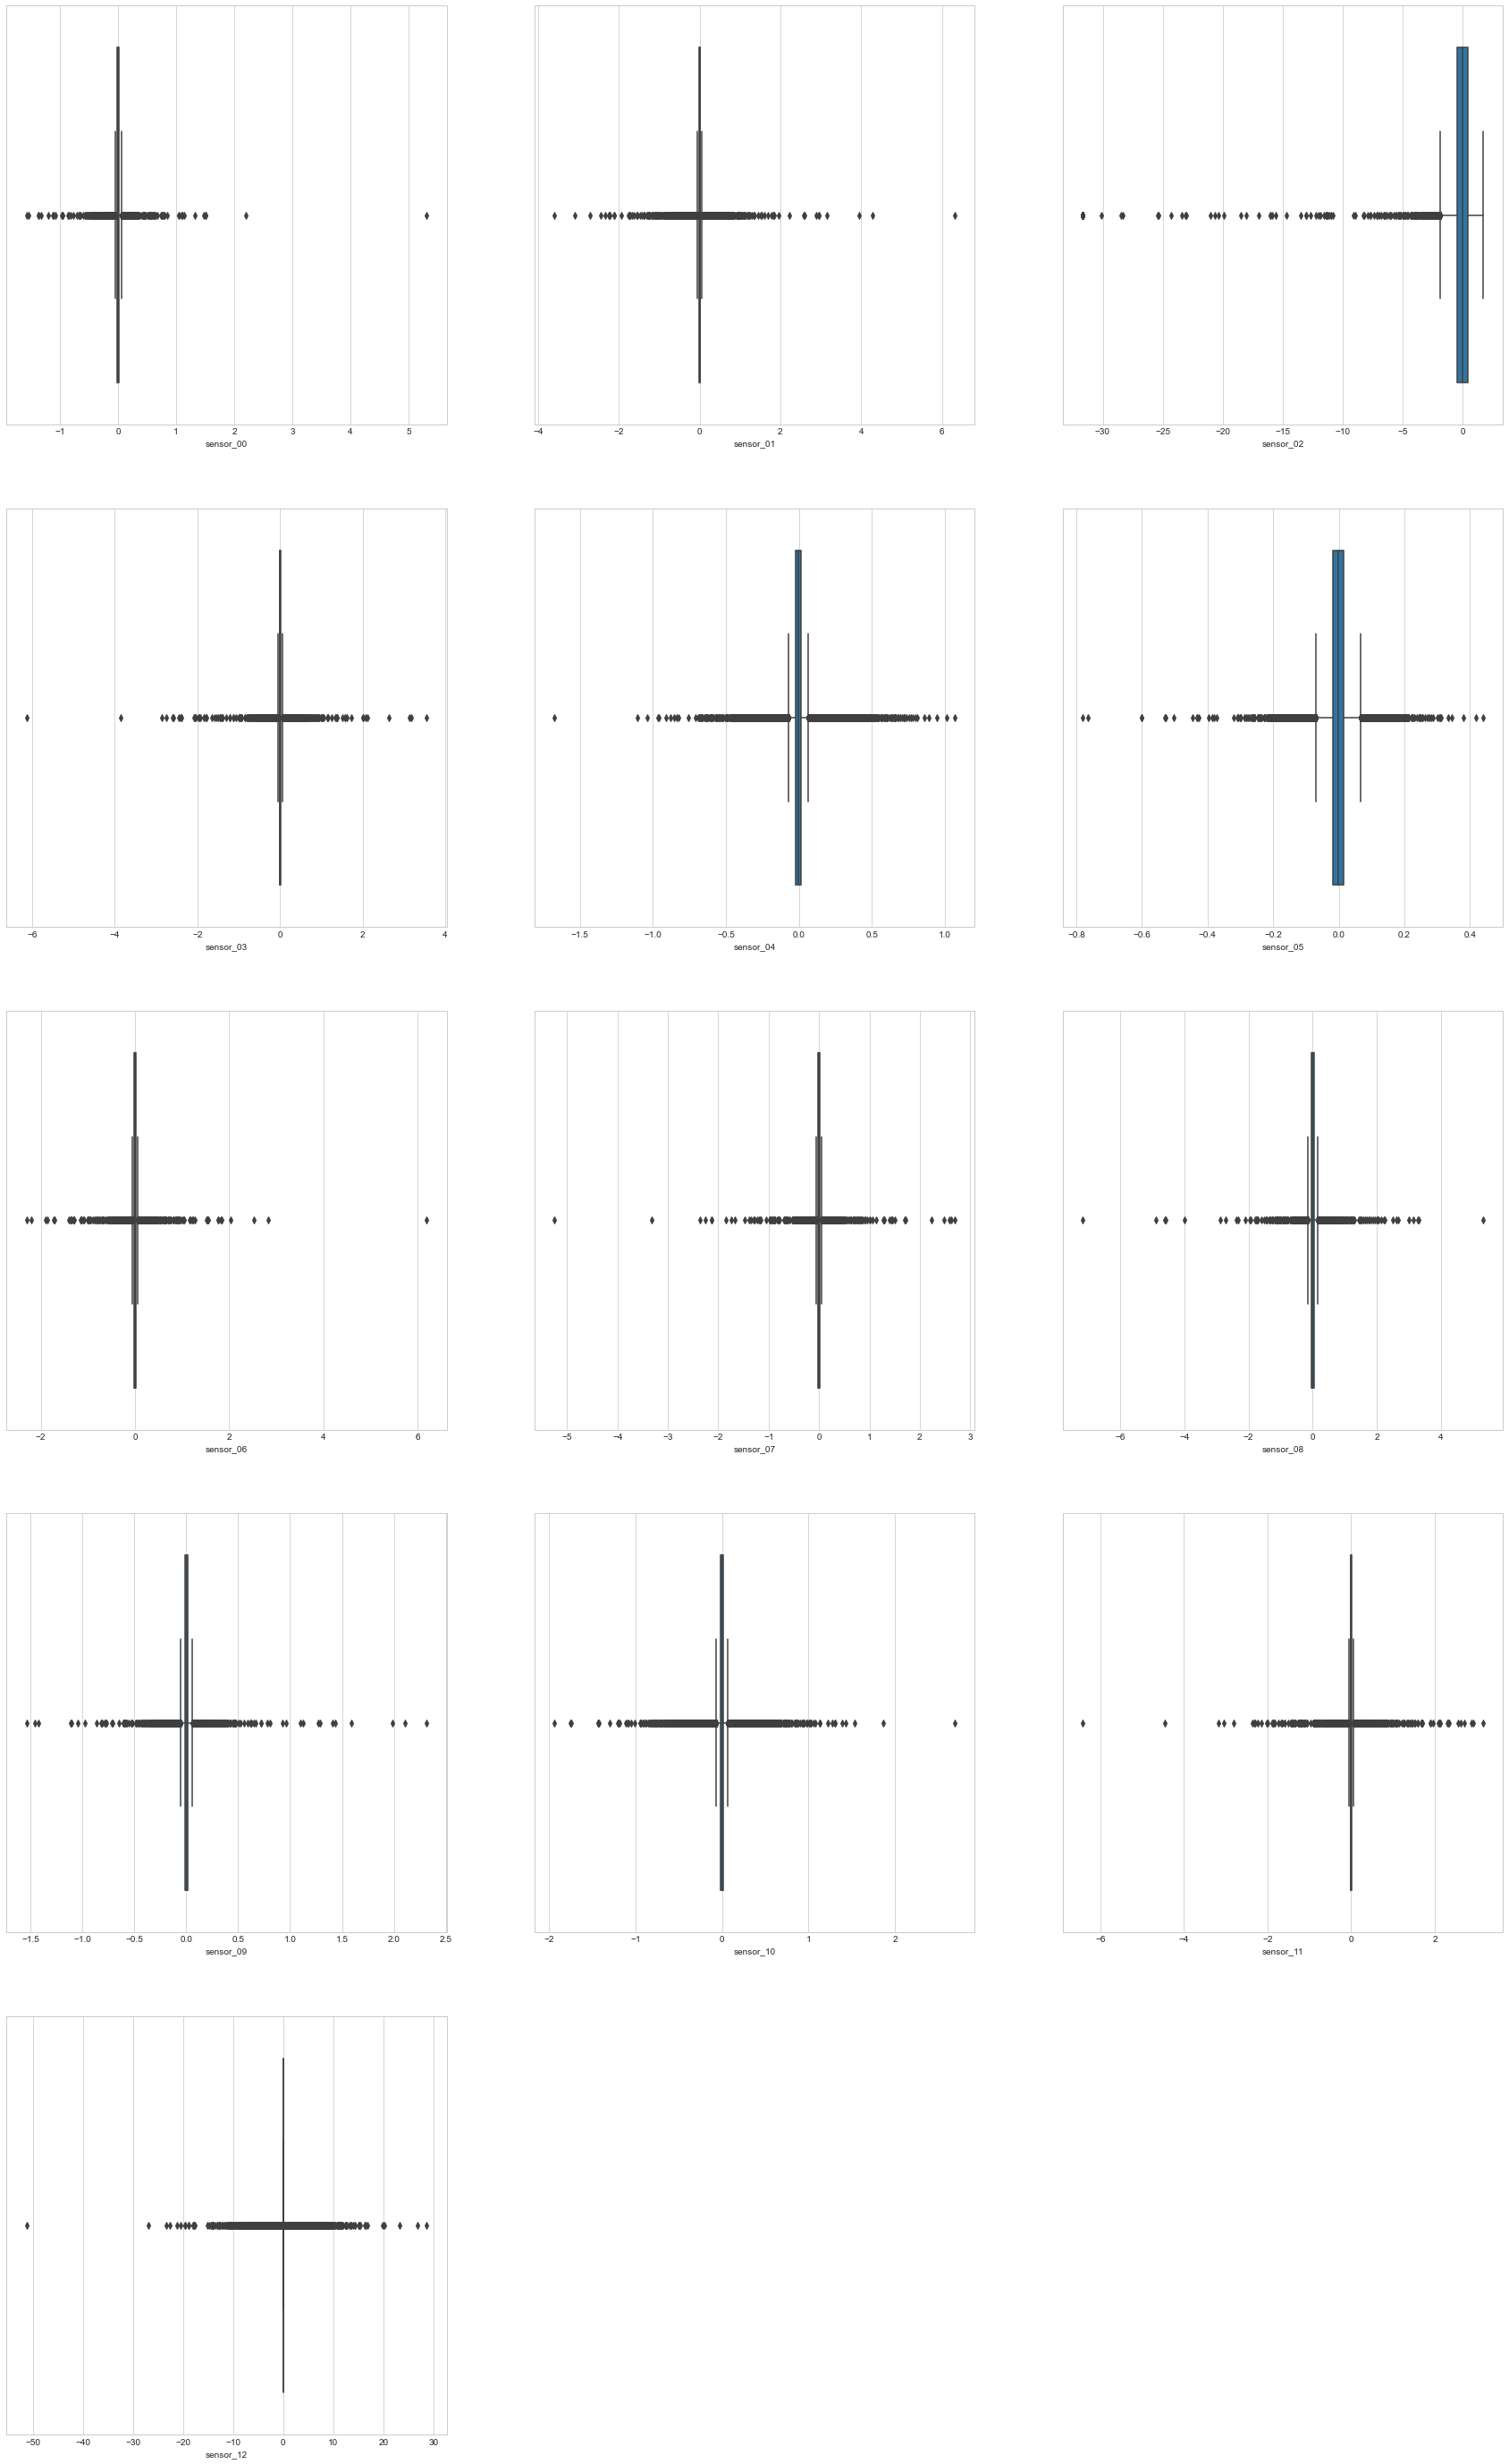

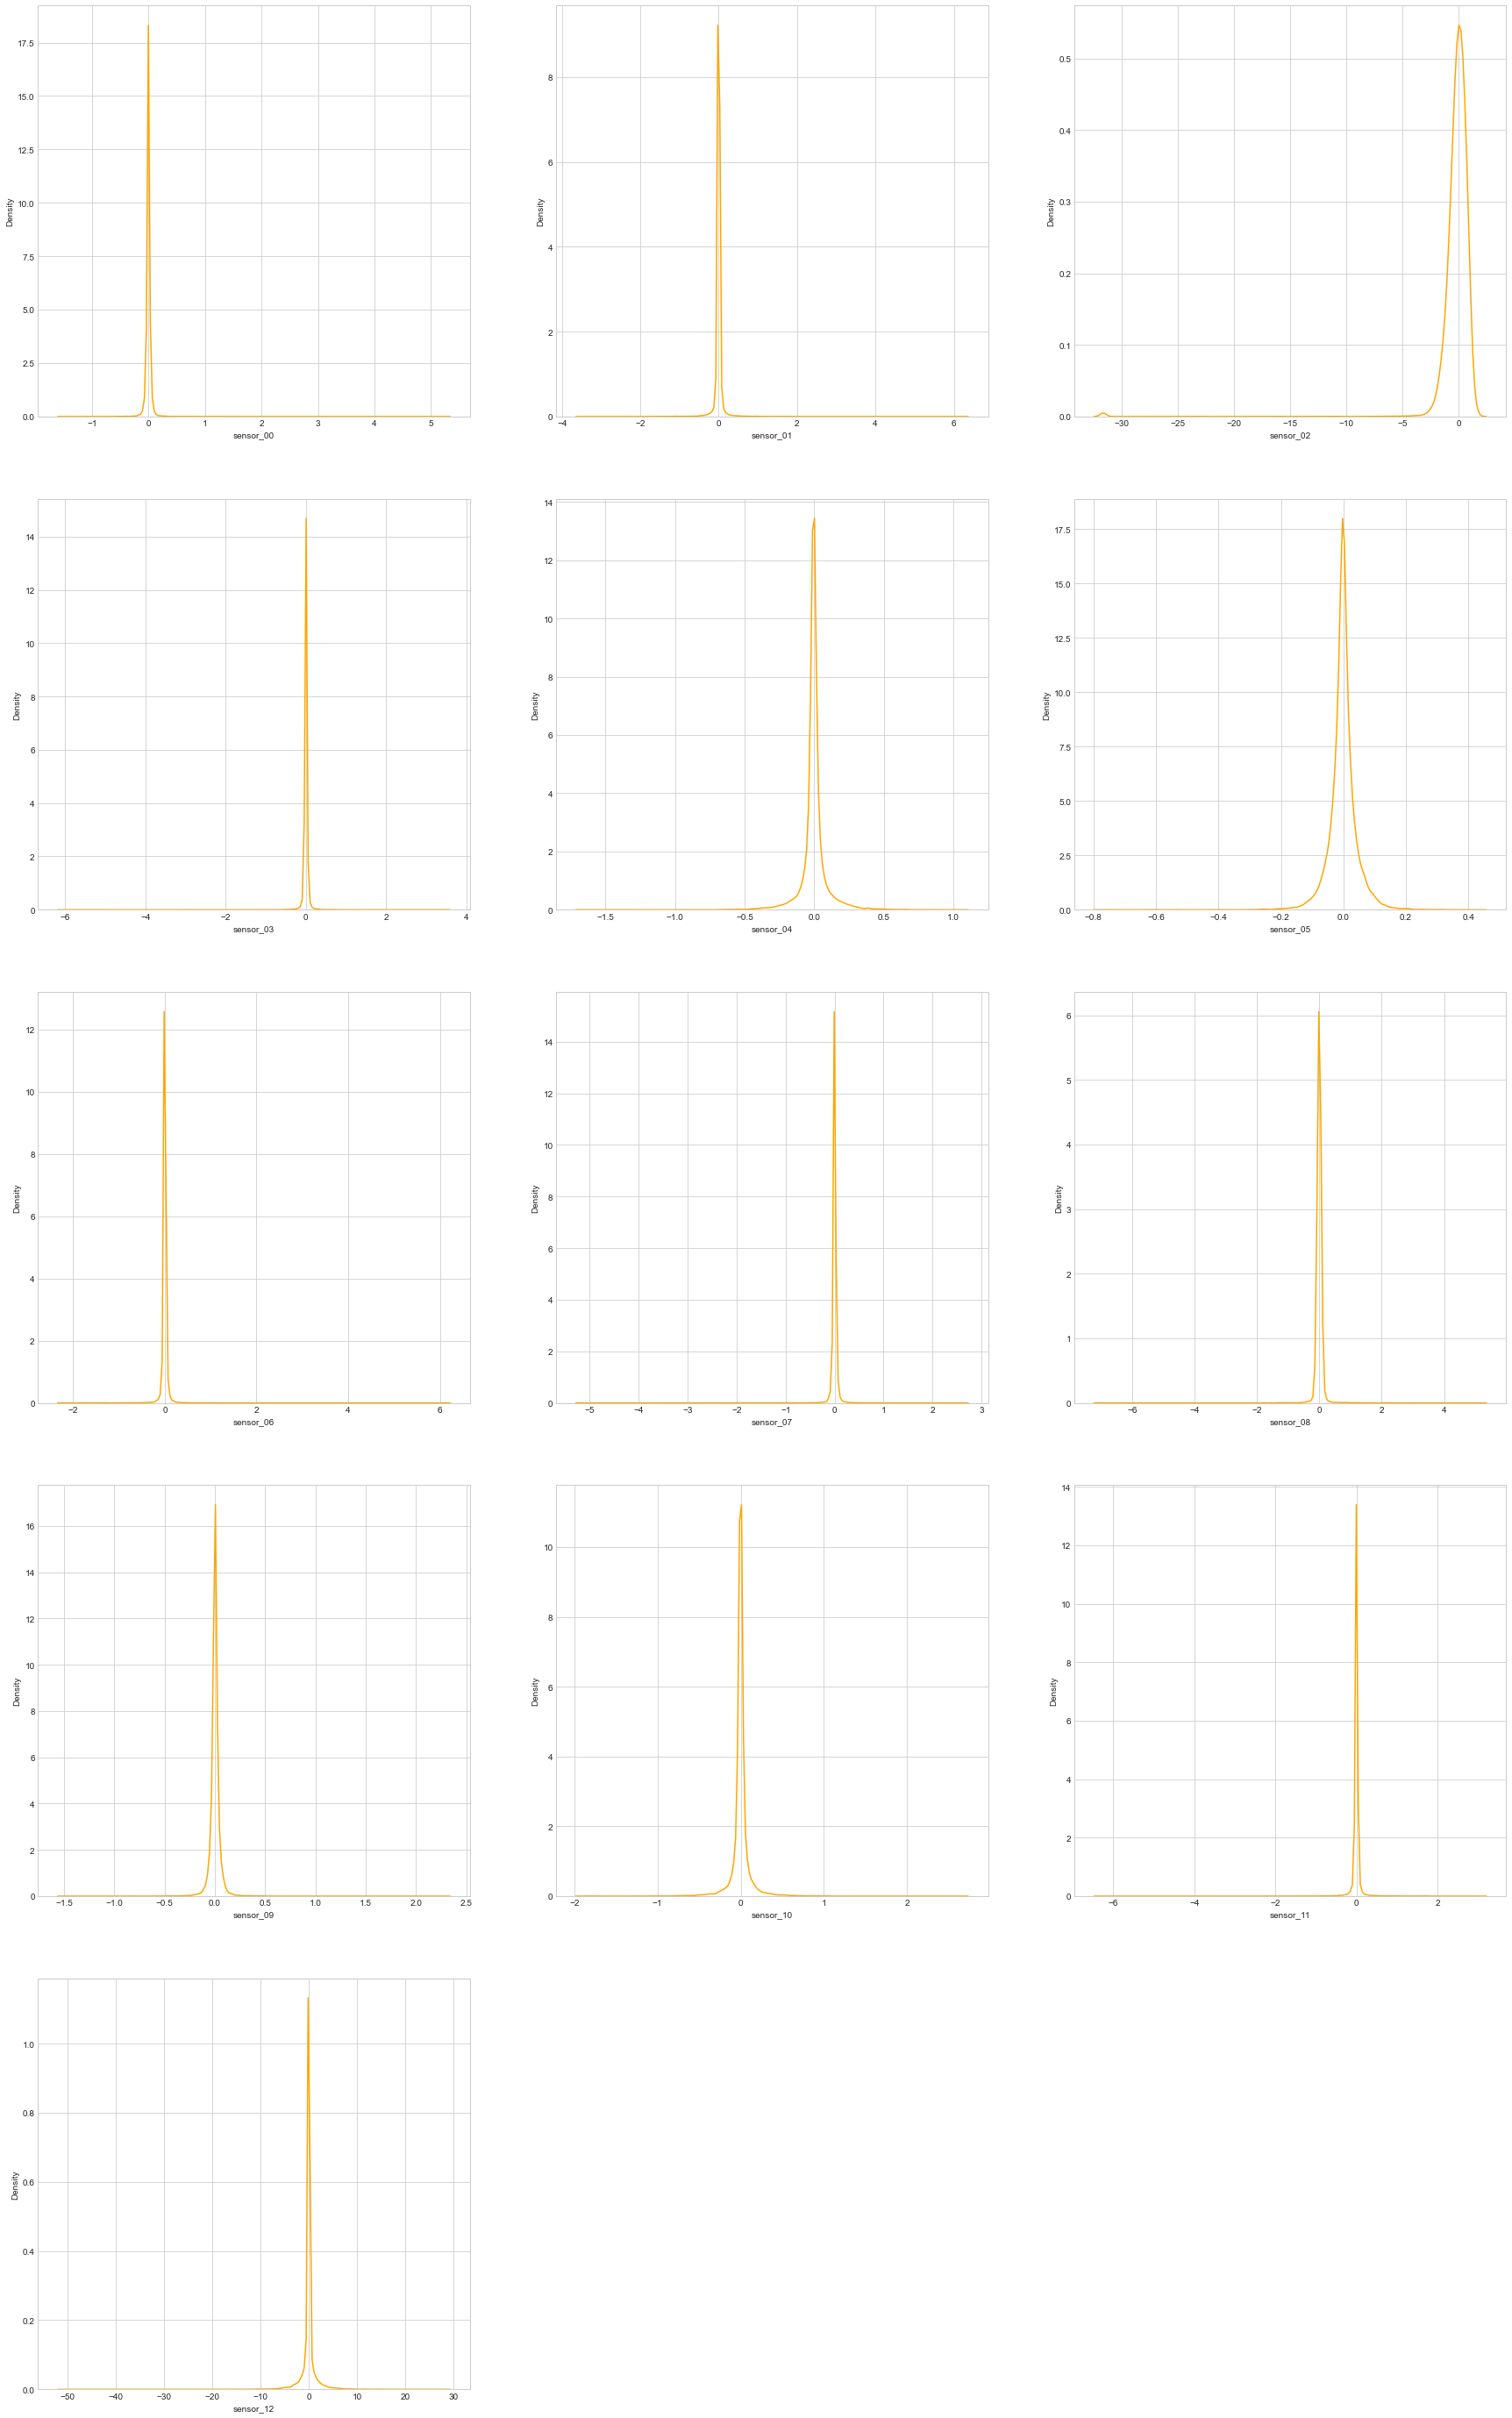

In [57]:
%%time
outlier(df_train, col1)

Dealing with outliers

In [58]:
df_train[col1].max()

sensor_00    5.31
sensor_01    6.32
sensor_02    1.67
sensor_03    3.55
sensor_04    1.07
sensor_05    0.44
sensor_06    6.19
sensor_07    2.69
sensor_08    5.30
sensor_09    2.31
sensor_10    2.69
sensor_11    3.15
sensor_12   28.63
dtype: float32

In [59]:
df_train[col1].min()

sensor_00    -1.58
sensor_01    -3.59
sensor_02   -31.66
sensor_03    -6.14
sensor_04    -1.67
sensor_05    -0.78
sensor_06    -2.30
sensor_07    -5.25
sensor_08    -7.16
sensor_09    -1.54
sensor_10    -1.93
sensor_11    -6.42
sensor_12   -51.33
dtype: float32

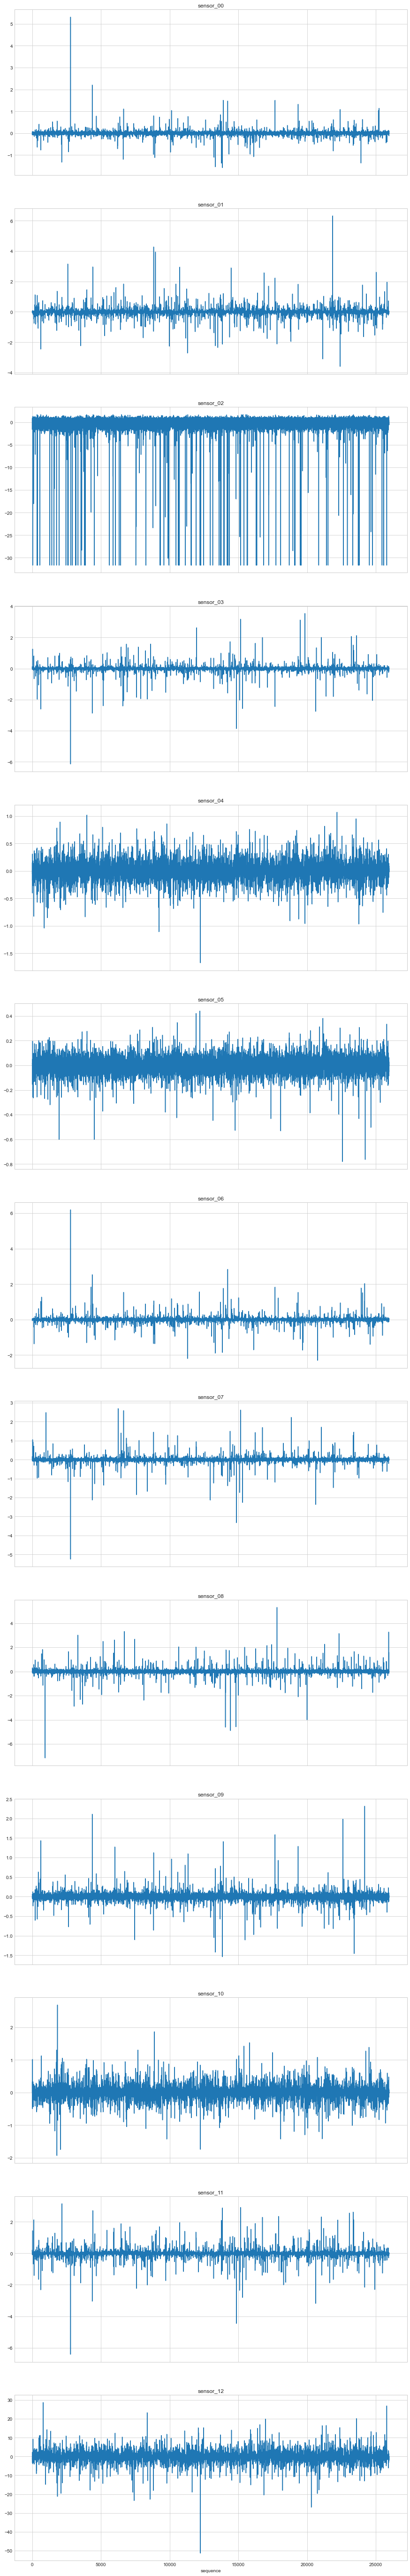

In [60]:
cols = ['sensor_00', 'sensor_01', 'sensor_02','sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07','sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']

fig, axs = plt.subplots(len(cols), 1, figsize=(15,100), sharex=True)
plt.xlabel('sequence')
for col, plt_ax in zip(cols, axs):
    plt_ax.title.set_text(col)
    df_train[col].plot(ax=plt_ax)

In [61]:
# sns.boxplot(x=df_train["state"], y=df_train["sequence"], palette="Blues")
# plt.show()

checking balance of target

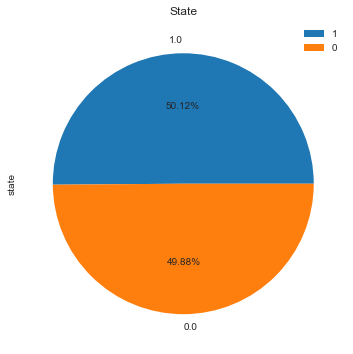

In [62]:
round(100*df_train['state'].value_counts(normalize=True),2).plot(kind='pie', figsize=(6, 6), autopct='%1.2f%%')
plt.title("State")
plt.legend(["1", "0"])
plt.show()

This is a balanced dataset

In [64]:
# sns.stripplot( x = df_train['state'], y= df_train['sequence'], data=df_train)

Heatmap

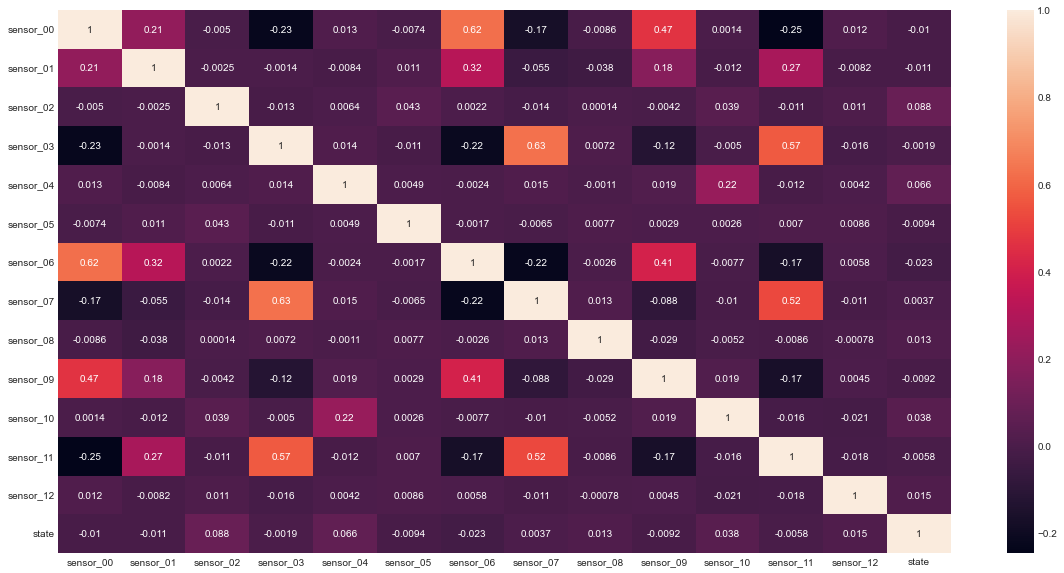

In [65]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

In [67]:
X = df_train.drop(['state'],1)
y = df_train['state']
X_test = df_test
X.shape, y.shape, X_test.shape

((25968, 13), (25968,), (12218, 13))

In [68]:
# !pip install dask-cuda

In [69]:
# !nvidia-smi

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=23)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape

((18177, 13), (18177,), (7791, 13), (7791,), (12218, 13))

In [71]:
# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
# cluster = LocalCUDACluster(threads_per_worker=1)
# c = Client(cluster)
# workers = c.has_what().keys()

In [72]:
# X_train, y_train = cuml.dask.common.utils.persist_across_workers(c,[X_train, y_train], workers=workers)

In [73]:
X_train

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
sequence,,,,,,,,,,,,,
10959,0.02,0.05,0.32,-0.02,0.01,-0.01,0.04,-0.00,-0.12,0.04,-0.02,0.01,0.53
15748,-0.03,-0.03,0.02,0.03,0.04,-0.02,-0.05,0.03,-0.03,-0.06,0.02,0.03,-1.42
3582,-0.11,0.10,0.63,0.01,-0.06,0.02,-0.07,0.00,0.04,-0.05,-0.02,0.48,0.23
24435,-0.01,0.01,-0.10,0.01,-0.00,0.07,0.00,0.01,-0.01,-0.04,0.02,0.02,-1.09
23243,-0.01,-0.17,-0.05,-0.13,-0.15,0.03,0.10,-0.10,-0.09,-0.01,-0.14,-0.44,3.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,-0.02,-0.03,0.37,0.00,0.01,-0.01,-0.01,0.00,0.04,-0.01,0.02,-0.01,0.01
9704,-0.02,-0.01,0.40,0.03,-0.38,0.02,-0.02,0.04,-0.07,-0.03,-0.19,0.01,1.57
11190,-0.02,0.00,0.36,0.05,0.08,0.01,-0.03,0.05,-0.02,-0.02,-0.62,0.05,-6.72


In [75]:
%%time
pt = PowerTransformer(copy=False)
X_train[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']] = pt.fit_transform(X_train[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']])
X_valid[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']] = pt.transform(X_valid[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']])
X_train.columns

Wall time: 552 ms


Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12'],
      dtype='object')

In [76]:
model_list = list()
resample  = list()
roc_train_list = list()
roc_valid_list = list()
auc_train_list = list()
auc_valid_list = list()
rcv_best_score = list()

In [77]:
model_LR = LogisticRegression()
model_DT = DecisionTreeClassifier(random_state = 23)
model_RF = RandomForestClassifier(random_state=23, oob_score = True)
model_LGBM = lightgbm.LGBMClassifier(objective = 'binary', random_state=23)

In [78]:
# training_models = {
#     'model_LR' : LogisticRegression(),
#     'model_DT' : DecisionTreeClassifier(random_state = 23),
#     'model_RF' : RandomForestClassifier(random_state=23, oob_score = True),
#     'model_LGBM' : lightgbm.LGBMClassifier(objective = 'binary', random_state=23)
# }

In [79]:
# params_DT = {
#     'max_depth': [5, 10, 20, 50, 100, 200],
#     'min_samples_leaf': [5, 10, 20, 50, 100, 200],
#     'min_samples_split' : [5, 10, 20, 50, 100, 200]
# } 
params_DT = {
    'max_depth': [100],
    'min_samples_leaf': [5],
    'min_samples_split' : [200]
} 
# 'min_samples_split': 50, 'min_samples_leaf': 5, 'max_depth': 200 #0.78
# ('max_depth', 100), ('min_samples_leaf', 5), ('min_samples_split', 200) #0.8

# params_RF = {    
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 20, 50, 100, 200],
#     'min_samples_leaf': [5, 10, 20, 50, 100, 200],
#     'min_samples_split' : [5, 10, 20, 50, 100, 200] 
# }
params_RF = {    
    'n_estimators': [100],
    'max_depth': [200],
    'min_samples_leaf': [10],
    'min_samples_split' : [5] 
}
# 'n_estimators': 200, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_depth': 50 #0.73
# ('max_depth', 200), ('min_samples_leaf', 10), ('min_samples_split', 5), ('n_estimators', 100) #0.74

# params_LGBM = {
#     'n_estimators': [50, 100, 200],
#     'boosting_type': ['gbdt','dart'],
#     'max_depth': [5, 10, 20, 50, 100, 200], 
#     'min_child_samples': [5, 10, 20, 50, 100, 200],
#     'subsample': [0.4,0.6,0.8],        
#     'learning_rate': [0.01, 0.05, 0.1]
# }
params_LGBM = {
    'n_estimators': [200],
    'boosting_type': ['gbdt'],
    'max_depth': [20], 
    'min_child_samples': [50],
    'subsample': [0.8],        
    'learning_rate': [0.1]
}
# 'subsample': 0.8, 'n_estimators': 100, 'min_child_samples': 50, 'max_depth': 200, 'learning_rate': 0.1, 'boosting_type': 'gbdt' #0.74
# ('boosting_type', 'gbdt'), ('learning_rate', 0.1), ('max_depth', 20), ('min_child_samples', 50), ('n_estimators', 200), ('subsample', 0.8) #0.76

In [80]:
def model_fit_evaluation1(model_model, X_train, y_train, X_valid, y_valid, algo=None, sampling=None):
    
    rcv_best = model_model.fit(X_train, y_train)
    
    y_train_prob = rcv_best.predict_proba(X_train)
    y_train_pred = rcv_best.predict(X_train)
    y_val_prob = rcv_best.predict_proba(X_valid)
    y_val_pred = rcv_best.predict(X_valid)
    
    matrix_train = confusion_matrix(y_train, y_train_pred)
    matrix_val = confusion_matrix(y_valid, y_val_pred)
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_valid, y_val_pred)
    roc_train = roc_auc_score(y_train, y_train_pred)
    roc_val = roc_auc_score(y_valid, y_val_pred)
    auc_train = roc_auc_score(y_train, y_train_prob[:,1])
    auc_val = roc_auc_score(y_valid, y_val_prob[:,1])
    
    print('AUCROC for train')
    print('='*60)
    print(roc_train,"\n")
    print('AUCROC for Val')
    print('='*60)
    print(roc_val,"\n")
    print('Confusion Matrix for train')
    print('='*60)
    print(matrix_train,"\n")
    print('Confusion Matrix for val')
    print('='*60)
    print(matrix_val,"\n")
    print('Classification Report for train')
    print('='*60)
    print(report_train,"\n")
    print('Classification Report for val')
    print('='*60)
    print(report_val,"\n")
    print('AUC-ROC prob for train')
    print('='*60)
    print(auc_train,'\n')
    print('AUC-ROC prob for val')
    print('='*60)
    print(auc_val,'\n')
    print('Roc-Auc-Curve for Train set')
    print('='*60)
    print(plot_roc_curve(model_LR, X_train, y_train),'\n')
    print('Roc-Auc-Curve for Val set')
    print('='*60)
    print(plot_roc_curve(model_LR, X_valid, y_valid),'\n')
    
    model_list.append(algo)
    resample.append(sampling)
    roc_train_list.append(roc_train)
    roc_valid_list.append(roc_val)
    auc_train_list.append(auc_train)
    auc_valid_list.append(auc_val)

In [81]:
def model_fit_evaluation2(model_model, params, X_train, y_train, X_valid, y_valid, algo=None, sampling=None):
    
    rcv = RandomizedSearchCV(model_model, params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=23)
    rcv.fit(X_train, y_train)    
    rcv_best = rcv.best_estimator_
    
    print('\n')
    print('best estimator : ', rcv_best)
    print('best parameters: ', rcv.best_params_)
    print('best score: ', rcv.best_score_)
    print('\n')

    y_train_prob = rcv_best.predict_proba(X_train)
    y_train_pred = rcv_best.predict(X_train)
    y_val_prob = rcv_best.predict_proba(X_valid)
    y_val_pred = rcv_best.predict(X_valid)
    
    matrix_train = confusion_matrix(y_train, y_train_pred)
    matrix_val = confusion_matrix(y_valid, y_val_pred)
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_valid, y_val_pred)
    roc_train = roc_auc_score(y_train, y_train_pred)
    roc_val = roc_auc_score(y_valid, y_val_pred)
    auc_train = roc_auc_score(y_train, y_train_prob[:,1])
    auc_val = roc_auc_score(y_valid, y_val_prob[:,1])
    
    print('AUCROC for train')
    print('='*60)
    print(roc_train,"\n")
    print('AUCROC for Val')
    print('='*60)
    print(roc_val,"\n")
    print('Confusion Matrix for train')
    print('='*60)
    print(matrix_train,"\n")
    print('Confusion Matrix for val')
    print('='*60)
    print(matrix_val,"\n")
    print('Classification Report for train')
    print('='*60)
    print(report_train,"\n")
    print('Classification Report for val')
    print('='*60)
    print(report_val,"\n")
    print('AUC-ROC prob for train')
    print('='*60)
    print(auc_train,'\n')
    print('AUC-ROC prob for val')
    print('='*60)
    print(auc_val,'\n')
    print('Roc-Auc-Curve for Train set')
    print('='*60)
    print(plot_roc_curve(rcv_best, X_train, y_train),'\n')
    print('Roc-Auc-Curve for Val set')
    print('='*60)
    print(plot_roc_curve(rcv_best, X_valid, y_valid),'\n')
    
    model_list.append(algo)
    resample.append(sampling)
    roc_train_list.append(roc_train)
    roc_valid_list.append(roc_val)
    auc_train_list.append(auc_train)
    auc_valid_list.append(auc_val)
    rcv_best_score.append(rcv.best_score_)

In [82]:
def model_fit_evaluation3(model_model, params, X_train, y_train, X_valid, y_valid, algo=None, sampling=None):
    
    rcv = BayesSearchCV(model_model, params, cv=5, scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=23)
    rcv.fit(X_train, y_train)    
    rcv_best = rcv.best_estimator_
    
    print('\n')
    print('best estimator : ', rcv_best)
    print('best parameters: ', rcv.best_params_)
    print('best score: ', rcv.best_score_)
    print('\n')

    y_train_prob = rcv_best.predict_proba(X_train)
    y_train_pred = rcv_best.predict(X_train)
    y_val_prob = rcv_best.predict_proba(X_valid)
    y_val_pred = rcv_best.predict(X_valid)
    
    matrix_train = confusion_matrix(y_train, y_train_pred)
    matrix_val = confusion_matrix(y_valid, y_val_pred)
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_valid, y_val_pred)
    roc_train = roc_auc_score(y_train, y_train_pred)
    roc_val = roc_auc_score(y_valid, y_val_pred)
    auc_train = roc_auc_score(y_train, y_train_prob[:,1])
    auc_val = roc_auc_score(y_valid, y_val_prob[:,1])
    
    print('AUCROC for train')
    print('='*60)
    print(roc_train,"\n")
    print('AUCROC for Val')
    print('='*60)
    print(roc_val,"\n")
    print('Confusion Matrix for train')
    print('='*60)
    print(matrix_train,"\n")
    print('Confusion Matrix for val')
    print('='*60)
    print(matrix_val,"\n")
    print('Classification Report for train')
    print('='*60)
    print(report_train,"\n")
    print('Classification Report for val')
    print('='*60)
    print(report_val,"\n")
    print('AUC-ROC prob for train')
    print('='*60)
    print(auc_train,'\n')
    print('AUC-ROC prob for val')
    print('='*60)
    print(auc_val,'\n')
    print('Roc-Auc-Curve for Train set')
    print('='*60)
    print(plot_roc_curve(rcv_best, X_train, y_train),'\n')
    print('Roc-Auc-Curve for Val set')
    print('='*60)
    print(plot_roc_curve(rcv_best, X_valid, y_valid),'\n')
    
    model_list.append(algo)
    resample.append(sampling)
    roc_train_list.append(roc_train)
    roc_valid_list.append(roc_val)
    auc_train_list.append(auc_train)
    auc_valid_list.append(auc_val)
    rcv_best_score.append(rcv.best_score_)

In [83]:
# model_fit_evaluation1(model_LR, X_train, y_train, X_valid, y_valid, 'Logistic Regression', 'without HPT')

In [84]:
# model_fit_evaluation1(model_DT, X_train, y_train, X_valid, y_valid, 'Decision Tree', 'without HPT')

In [85]:
# model_fit_evaluation1(model_LGBM, X_train, y_train, X_valid, y_valid, 'LGBM', 'without HPT')

In [86]:
# model_fit_evaluation1(model_RF, X_train, y_train, X_valid, y_valid, 'Random Forest', 'without HPT')

In [87]:
# eval_df1 = pd.DataFrame({'model': model_list, 'resample':resample, 'roc_train_list':roc_train_list, 'roc_valid_list':roc_valid_list, 'auc_train_list': auc_train_list, 'auc_valid_list': auc_valid_list})
# eval_df1

In [88]:
# %%time
# model_fit_evaluation2(model_DT, params_DT, X_train, y_train, X_valid, y_valid, 'DT', 'with HPT')

In [89]:
# %%time
# model_fit_evaluation3(model_DT, params_DT, X_train, y_train, X_valid, y_valid, 'DT', 'with HPT')

In [90]:
# %%time
# model_fit_evaluation2(model_LGBM, params_LGBM, X_train, y_train, X_valid, y_valid, 'LGBM', 'with HPT')

In [91]:
# %%time
# model_fit_evaluation3(model_LGBM, params_LGBM, X_train, y_train, X_valid, y_valid, 'LGBM', 'with HPT')

In [92]:
# %%time
# model_fit_evaluation2(model_RF, params_RF, X_train, y_train, X_valid, y_valid, 'RF', 'with HPT')

In [93]:
# %%time
# model_fit_evaluation3(model_RF, params_RF, X_train, y_train, X_valid, y_valid, 'RF', 'with HPT')

In [94]:
# c.close()
# cluster.close()

In [95]:
# eval_df2 = pd.DataFrame({'model': model_list, 'resample':resample, 'roc_train_list':roc_train_list, 'roc_valid_list':roc_valid_list, 'auc_train_list': auc_train_list, 'auc_valid_list': auc_valid_list, 'rcv_best_score':rcv_best_score})
# eval_df2

In [97]:
%%time
pt = PowerTransformer(copy=False)
X[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']] = pt.fit_transform(X[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']])
X_test[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']] = pt.transform(X_test[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']])
X.shape, X_test.shape

Wall time: 745 ms


((25968, 13), (12218, 13))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

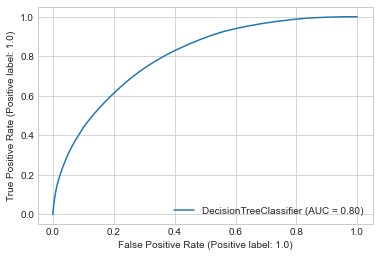

In [98]:
rcv = BayesSearchCV(model_DT, params_DT, cv=5, scoring='roc_auc', n_iter=20, n_jobs=-1, verbose=1, random_state=23)

rcv.fit(X, y)    
rcv_best = rcv.best_estimator_

print('\n')
print('best estimator : ', rcv_best)
print('best parameters: ', rcv.best_params_)
print('best score: ', rcv.best_score_)
print('\n')

y_train_prob = rcv_best.predict_proba(X)
y_train_pred = rcv_best.predict(X)
y_test_prob = rcv_best.predict_proba(X_test)
y_test_pred = rcv_best.predict(X_test)

matrix_train = confusion_matrix(y, y_train_pred)
report_train = classification_report(y, y_train_pred)
roc_train = roc_auc_score(y, y_train_pred)
auc_train = roc_auc_score(y, y_train_prob[:,1])

print('AUCROC for train')
print('='*60)
print(roc_train,"\n")
print('Confusion Matrix for train')
print('='*60)
print(matrix_train,"\n")
print('Classification Report for train')
print('='*60)
print(report_train,"\n")
print('AUC-ROC prob for train')
print('='*60)
print(auc_train,'\n')
print('Roc-Auc-Curve for Train set')
print('='*60)
print(plot_roc_curve(rcv_best, X, y),'\n')

# best estimator :  DecisionTreeClassifier(max_depth=100, min_samples_leaf=5, min_samples_split=200,
#                        random_state=23)
# best parameters:  OrderedDict([('max_depth', 100), ('min_samples_leaf', 5), ('min_samples_split', 200)])
# best score:  0.7626176945590644
#0.87 auc

In [99]:
y_prob = [i[1] for i in y_test_prob]
print(len(y_prob))

12218


In [100]:
predictions = y_prob
submission = pd.DataFrame({ 'sequence' : df_test['sequence'], 'state': predictions })
submission.shape

KeyError: 'sequence'

In [ ]:
submission

In [ ]:
submission.state = [0 if i < 0.5 else 1 for i in submission['state']]    
submission

,sequence,state
0,25968,0
1,25968,0
2,25968,1
3,25968,1
4,25968,0
...,...,...
733075,38185,0
733076,38185,1
733077,38185,0
733078,38185,0


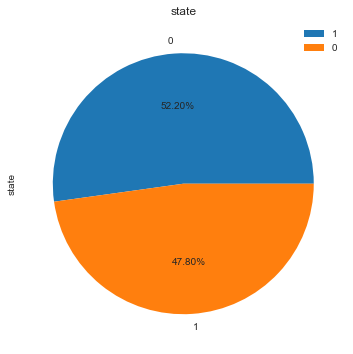

In [ ]:
round(100*submission['state'].value_counts(),2).plot(kind='pie', figsize=(6, 6), autopct='%1.2f%%')
plt.title("state")
plt.legend(["1", "0"])
plt.show()

In [ ]:
# predictions_pred = y_test_pred
# submission_pred = pd.DataFrame({ 'sequence' : test['sequence'], 'state': predictions_pred })
# submission_pred.shape

In [ ]:
# round(100*submission_pred['state'].value_counts(),2).plot(kind='pie', figsize=(6, 6), autopct='%1.2f%%')
# plt.title("state")
# plt.legend(["1", "0"])
# plt.show()

In [ ]:
# submission.to_csv('submission.csv', index = False)
submission.to_csv(r'C:\Users\getch\Documents\GitHub\my_DataScience_MachineLearning_projects\Tabular_playground_April22\submission.csv', index = False)
submission

,sequence,state
0,25968,0
1,25968,0
2,25968,1
3,25968,1
4,25968,0
...,...,...
733075,38185,0
733076,38185,1
733077,38185,0
733078,38185,0


In [ ]:
submission.sequence.value_counts()

25968    60
34116    60
34107    60
34108    60
34109    60
         ..
30043    60
30044    60
30045    60
30046    60
38185    60
Name: sequence, Length: 12218, dtype: int64